In [1]:
from torchvision import transforms, models
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Set the environment variable
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'


load vgg19 features
Freeze all pamameters in vgg and only optimizing the target image

In [2]:
vgg = models.vgg19().features

for param in vgg.parameters():
    param.requires_grad_(False)

select between cuda, mps and cpu

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

load image & convert tensor to image

In [4]:
def load_image(img_path, max_size=400, shape=None):

    image = Image.open(img_path).convert('RGB')
    size = min(max_size, max(image.size))

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3, :, :].unsqueeze(0)
    return image


def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + \
        np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

Gram Matrix

In [5]:
def gram_matrix(tensor):
    _, C, H, W = tensor.size()
    tensor = tensor.view(C, H * W)
    # Compute the Gram matrix
    gram = torch.mm(tensor, tensor.t())

    return gram


Get Features

In [6]:
def get_features(image, model, target_layers=['0', '5', '10', '19', '21', '28']):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in target_layers:
            features[name] = x
    return features

Start Proecess

In [7]:
# load in content and style image
content = load_image('images/octopus.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('images/hockney.jpg', shape=content.shape[-2:]).to(device)

content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
style_grams = {name:gram_matrix(style_features[name]) for name in style_features}

target = content.clone().requires_grad_(True).to(device)

Weights for styles

In [8]:
style_weights = {'0':1, '5':0.75, '10':0.2, '19':0.2, '21':0.2, '28':0.2}
content_weight = 1  # alpha
style_weight = 1e6  # beta

Start training

In [9]:
# for displaying the target image, intermittently
import tqdm


show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in tqdm.tqdm(range(1, steps+1)):
    
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['21'] - content_features['21'])**2)
    
    style_loss = 0
    
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())

 20%|██        | 407/2000 [00:13<00:48, 32.70it/s]

Total loss:  76326.0078125


 40%|████      | 807/2000 [00:26<00:38, 30.69it/s]

Total loss:  11167.48828125


 60%|██████    | 1207/2000 [00:39<00:25, 30.70it/s]

Total loss:  3618.162841796875


 80%|████████  | 1607/2000 [00:52<00:12, 30.72it/s]

Total loss:  1857.097900390625


100%|██████████| 2000/2000 [01:05<00:00, 30.51it/s]

Total loss:  1183.215087890625


Final result

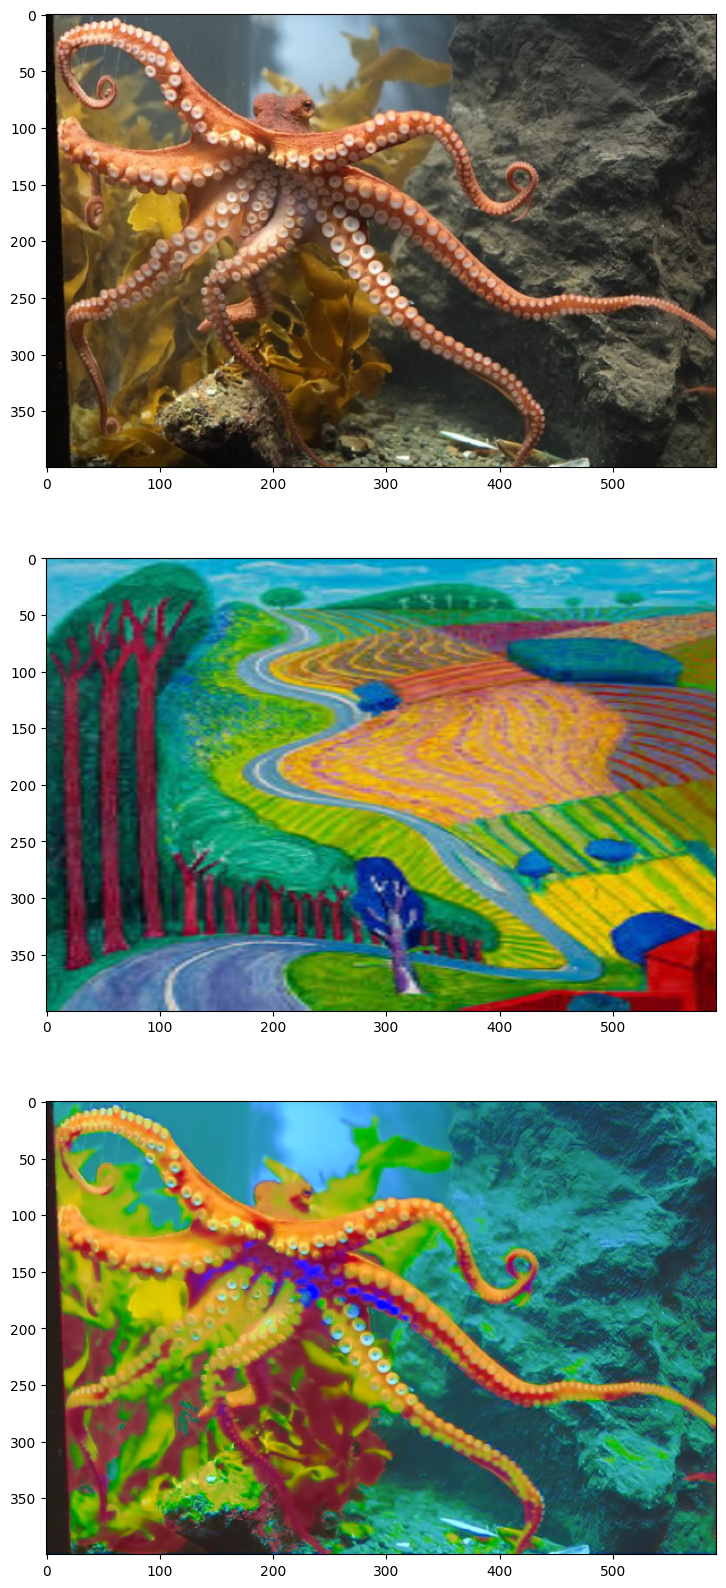

In [10]:
# display content and final, target image
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(40, 20))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))
ax3.imshow(im_convert(target))